In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.decomposition import PCA

# directories 
MetaDataDir = "./02_Data/0001_Database.xlsx"
WeldDir = "./02_Data/02_Weldqas"
AudioDir = "./02_Data/01_Audio"

# create tf.data.Dataset objects for training, validation, and testing
def make_dataset(audio, welding, mask, labels, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'audio_input': audio,
            'welding_input': welding,
            'audio_mask_input': mask
        },
        labels
    ))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(labels), reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


def scale_sequence_dataset(X_train, X_val, X_test, clip=True, clip_range=(-5, 5)):
    """
    Skaliert Sequenzdaten (shape: [samples, timesteps, features]) mit StandardScaler.
    Nur train wird gefittet, val/test transformiert.
    """
    # Shape prüfen
    n_train, t, f = X_train.shape

    # Reshape auf 2D: [samples * timesteps, features]
    X_train_2d = X_train.reshape(-1, f)
    X_val_2d = X_val.reshape(-1, f)
    X_test_2d = X_test.reshape(-1, f)

    # Scaler fitten & anwenden
    scaler = StandardScaler()
    X_train_scaled_2d = scaler.fit_transform(X_train_2d)
    X_val_scaled_2d = scaler.transform(X_val_2d)
    X_test_scaled_2d = scaler.transform(X_test_2d)

    # Clipping optional
    if clip:
        X_train_scaled_2d = np.clip(X_train_scaled_2d, *clip_range)
        X_val_scaled_2d = np.clip(X_val_scaled_2d, *clip_range)
        X_test_scaled_2d = np.clip(X_test_scaled_2d, *clip_range)

    # Zurück zu 3D-Form
    X_train_scaled = X_train_scaled_2d.reshape(n_train, t, f)
    X_val_scaled = X_val_scaled_2d.reshape(X_val.shape)
    X_test_scaled = X_test_scaled_2d.reshape(X_test.shape)

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler



In [25]:
file = tf.keras.utils
# load Excel
meta_df = pd.read_excel("./02_Data/0001_Database.xlsx", sheet_name="Database", skiprows=10)
# only use data marked as usable and with iO/niO labels
meta_df = meta_df[meta_df["Usable"] == "Yes"]
meta_df = meta_df[meta_df["Dataset"].isin(["iO", "niO"])]
#labeling error io and nio based on error type in forceed error column 
meta_df["label"] = meta_df["Forced Error Type"].map({"iO": 0, "oil": 1, "offset": 2, "Tilt": 3})
# Add file column based on "Number of Measurement"
meta_df["file"] = meta_df["Number of Measurement"].astype(str) + ".csv"

meta_df = meta_df[["Number of Measurement", "file", "label", "Dataset", "Audio", "Forced Error Type"]]

meta_df.head()



,Number of Measurement,file,label,Dataset,Audio,Forced Error Type
0,169,169.csv,0,iO,Yes,iO
1,170,170.csv,0,iO,Yes,iO
2,171,171.csv,0,iO,Yes,iO
3,172,172.csv,0,iO,Yes,iO
4,173,173.csv,0,iO,Yes,iO


In [27]:
# imbalance check 
io, oil, offset, tilt = np.bincount(meta_df['label'])
total = io + offset + oil + tilt
print('Samples:\n    Total: {}\n    iO: {} ({:.2f}% of total)\n    oil: {} ({:.2f}% of total)\n    tilt: {} ({:.2f}% of total)\n    offset: {} ({:.2f}% of total)\n'.format(
    total, io, 100 * io / total, oil, 100 * oil / total, tilt, 100 * tilt / total, offset, 100 * offset / total))

Samples:
    Total: 260
    iO: 50 (19.23% of total)
    oil: 50 (19.23% of total)
    tilt: 80 (30.77% of total)
    offset: 80 (30.77% of total)



Shape von X: (260, 12), y: (260,)
Anzahl der Features: 12, Anzahl der Klassen: 4
[[232.7710912571793, 165.08144086912375, 11.2, 448.2, -0.050293548267191256, -1.8716728945801706, 18.709310784939376, 16.815222125856838, -0.83, 44.92, 0.08034419956138791, -1.7865408146990298], [232.82788522848037, 164.96137681938342, 10.8, 472.1, -0.04791110148687837, -1.873858553243466, 19.30373645058448, 16.711087937596368, -0.78, 43.84, 0.006986543229091183, -1.8150478473429847], [235.1862611654615, 166.50517818163925, 11.7, 460.9, -0.05621080834679693, -1.8673395164786215, 19.167518077413867, 16.878172045097397, -0.88, 44.23, 0.0398150281717001, -1.7936299669117743], [235.30755158476921, 166.57494679056774, 11.7, 458.9, -0.056445717061798364, -1.8659707539518062, 19.15210380770049, 16.97282724159565, -0.83, 45.01, 0.08238516948207801, -1.7487996022677947], [235.32178070548238, 166.45821545208864, 10.8, 474.6, -0.0526894274805213, -1.8685128436755445, 18.488748406289844, 15.953011081852559, -0.83, 42.

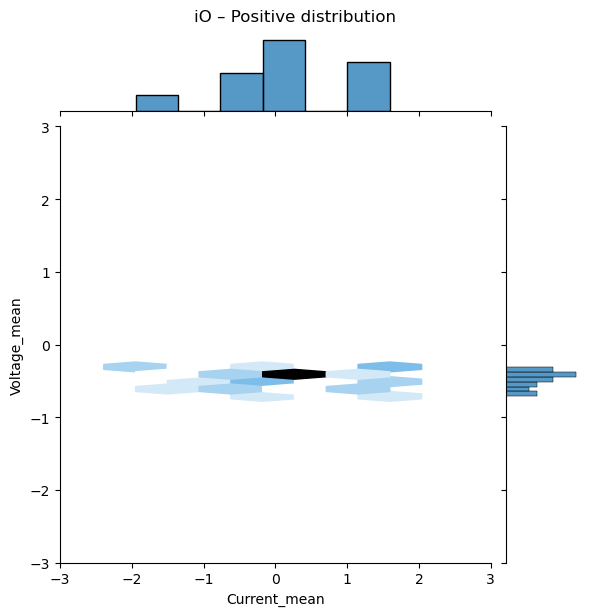

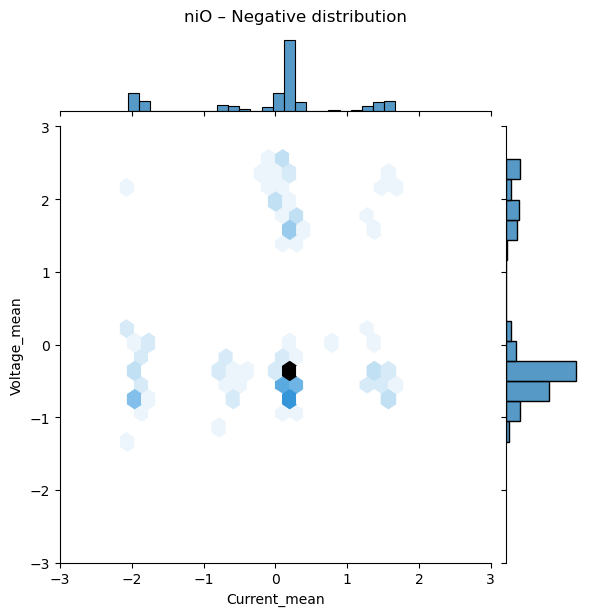

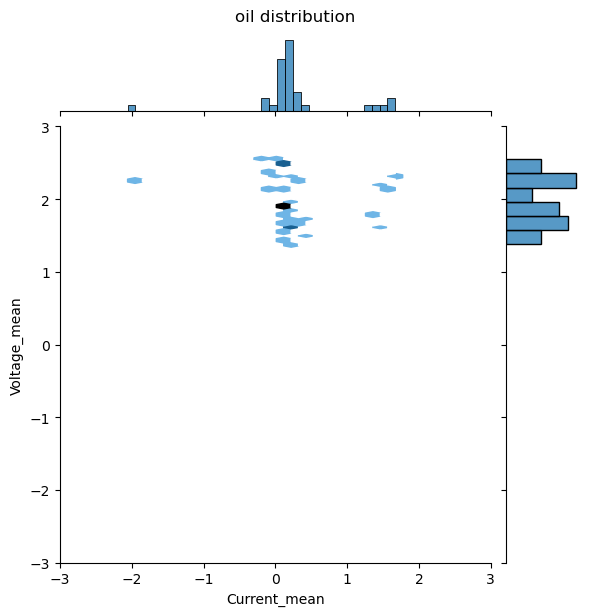

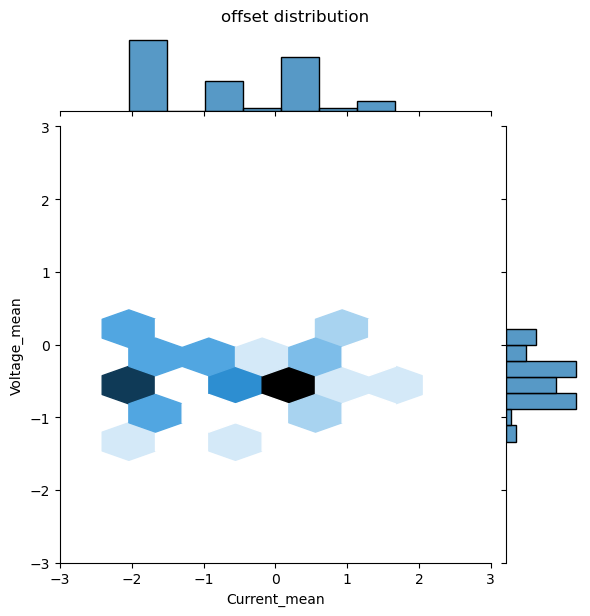

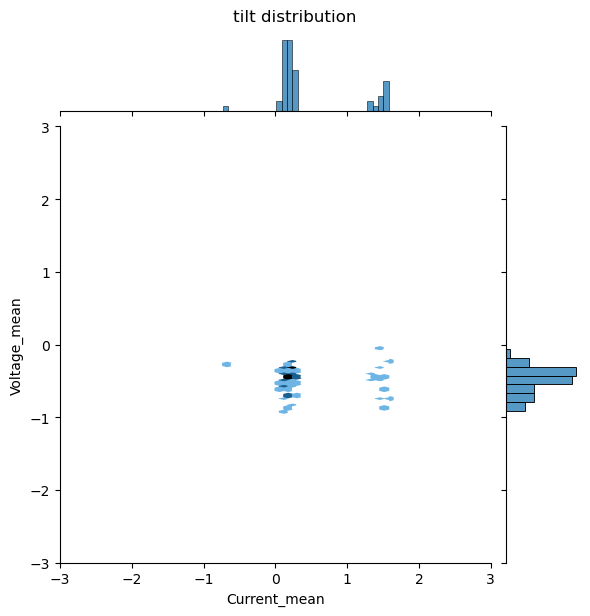

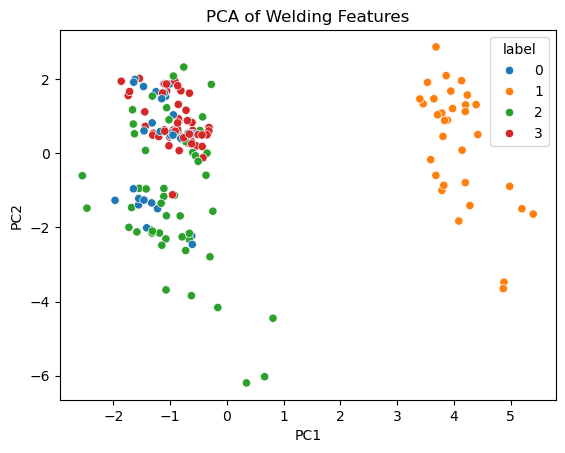

In [ ]:
def extract_features_from_welding(path):
    try:
        df = pd.read_csv(path)
        df = df.drop(columns=["Time [s]", "Wire [m/min]"])
    except Exception as e:
        print(f"Fehler beim Laden der Datei {path}: {e}")
        return None

    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.empty:
        return None

    features = []
    for col in numeric_df.columns:
        series = numeric_df[col]
        features.extend([
            series.mean(),
            series.std(),
            series.min(),
            series.max(),
            series.skew(),
            series.kurt()
        ])
    return features

feature_list = []
feature_names = ["Current_mean", "Current_std", "Current_min", "Current_max", "Current_skew", "Current_kurt",
                 "Voltage_mean", "Voltage_std", "Voltage_min", "Voltage_max", "Voltage_skew", "Voltage_kurt"]
labels = []

for _, row in meta_df.iterrows():
    weld_path = os.path.join(WeldDir, row["file"])
    features = extract_features_from_welding(weld_path)
    if features is not None:
        feature_list.append(features)
        labels.append(row["label"])

X = np.array(feature_list)
y = np.array(labels)
print(f"Shape von X: {X.shape}, y: {y.shape}")
print(f"Anzahl der Features: {X.shape[1]}, Anzahl der Klassen: {len(np.unique(y))}")
print(feature_list[:5])  # Zeigt die ersten 5 Feature-Vektoren an


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)
print(f"Trainingsdaten: {X_train.shape}, Validierungsdaten: {X_val.shape}, Testdaten: {X_test.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

train_features = np.clip(X_scaled, -5, 5)
val_features = np.clip(X_val_scaled, -5, 5)
test_features = np.clip(X_test_scaled, -5, 5)

print('\nTraining features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)
print('\nTraining labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print('Test labels shape:', y_test.shape)


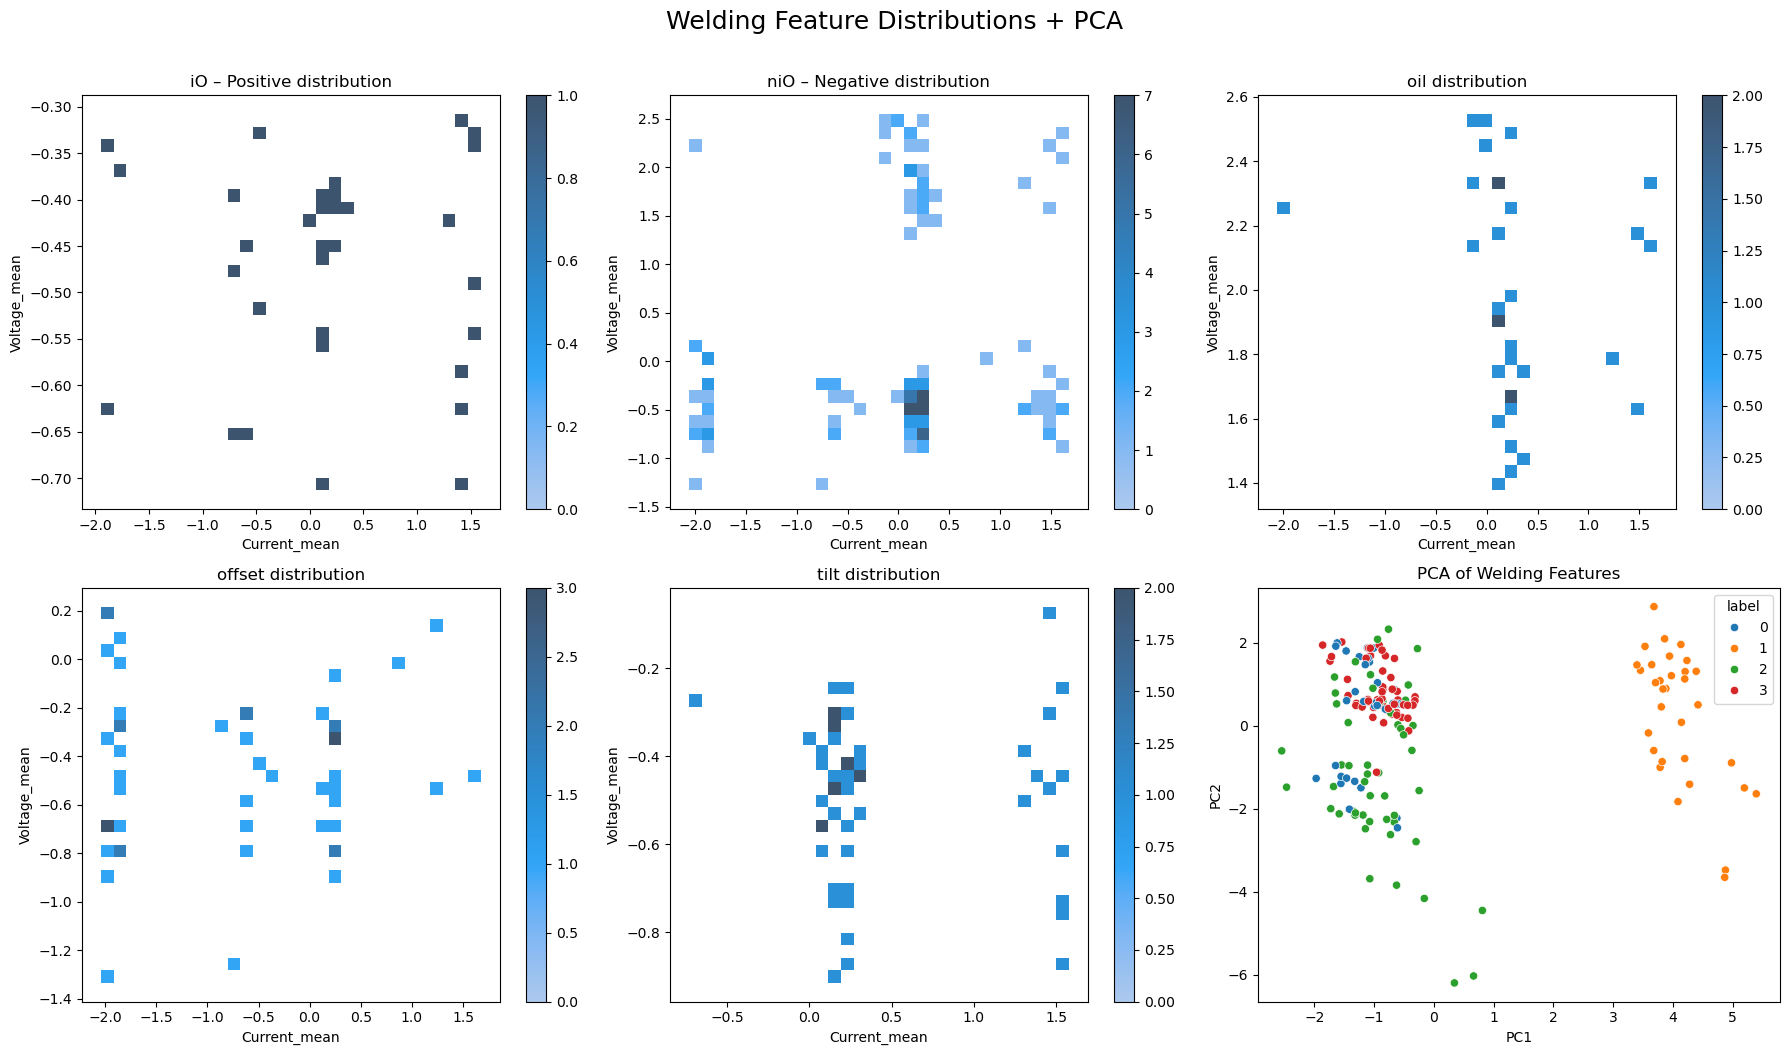

PCA components: [[ 0.04734097  0.20341958 -0.10041223  0.16957989  0.15192648 -0.14824056
   0.47674882  0.47111479  0.18263689  0.46921746 -0.37664069 -0.16692629]
 [ 0.51194656  0.45782972  0.08290079  0.14910042 -0.24823942  0.42534845
  -0.01600346  0.07407902 -0.3245148   0.061401    0.21704278 -0.30777226]
 [-0.38966123  0.06543901  0.29396462  0.31500131  0.54311266 -0.11278472
  -0.09419483  0.02111685 -0.25496926 -0.02783028  0.26336128 -0.45396859]]
PCA explained variance ratio: [0.35401945 0.22387527 0.12569313]


In [63]:

# --- Data preparation ---
features_df = pd.DataFrame(X_scaled, columns=feature_names)
labels_df = pd.Series(y_train, name='label')

# --- PCA transformation ---
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
pca_df["label"] = y_train

# --- Subplots setup ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# 1. iO (label == 0)
pos_df = features_df[labels_df == 0]
sns.histplot(
    x=pos_df["Current_mean"], y=pos_df["Voltage_mean"],
    bins=30, pmax=0.9, ax=axes[0], cbar=True
)
axes[0].set_title("iO – Positive distribution")
#axes[0].set_xlim(-3, 3)
#axes[0].set_ylim(-3, 3)

# 2. niO (label != 0)
neg_df = features_df[labels_df != 0]
sns.histplot(
    x=neg_df["Current_mean"], y=neg_df["Voltage_mean"],
    bins=30, pmax=0.9, ax=axes[1], cbar=True
)
axes[1].set_title("niO – Negative distribution")
#axes[1].set_xlim(-3, 3)
#axes[1].set_ylim(-3, 3)

# 3–5. oil, offset, tilt
label_map = {1: "oil", 2: "offset", 3: "tilt"}
for i, (label_val, label_name) in enumerate(label_map.items()):
    df = features_df[labels_df == label_val]
    sns.histplot(
        x=df["Current_mean"], y=df["Voltage_mean"],
        bins=30, pmax=0.9, ax=axes[i + 2], cbar=True
    )
    axes[i + 2].set_title(f"{label_name} distribution")
    #axes[i + 2].set_xlim(-3, 3)
    #axes[i + 2].set_ylim(-3, 3)

# 6. PCA plot
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2", hue="label",
    palette="tab10", ax=axes[5],
    legend=True  # Optional: set True if you want legend inside plot
)
axes[5].set_title("PCA of Welding Features")

# --- Final touches ---
fig.tight_layout()
fig.suptitle("Welding Feature Distributions + PCA", fontsize=18, y=1.05)
plt.show()

print(f"PCA components: {pca.components_}")
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")


In [ ]:
# define model and weights to compile

train_input = X_pca#train_features
val_input = pca.transform(X_val_scaled)  #val_features
test_input = pca.transform(X_test_scaled) #test_features

model = models.Sequential([
    layers.Input(shape=(train_input.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,028 (35.27 KB)

 Trainable params: 9,028 (35.27 KB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: 1.296875, 1: 1.296875, 2: 0.8137254901960784, 3: 0.8137254901960784}


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3312 - loss: 1.3691 - val_accuracy: 0.7143 - val_loss: 1.2009
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4271 - loss: 1.3041 - val_accuracy: 0.7619 - val_loss: 1.0978
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6128 - loss: 1.1349 - val_accuracy: 0.7381 - val_loss: 1.0216
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5722 - loss: 1.0461 - val_accuracy: 0.6667 - val_loss: 0.9638
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6195 - loss: 0.9473 - val_accuracy: 0.6667 - val_loss: 0.9200
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5998 - loss: 0.8725 - val_accuracy: 0.6429 - val_loss: 0.8896
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5852 - loss: 0.8455 - val_accuracy: 0.6667 - val_loss: 0.8674
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5971 - loss: 0.8187 - val_accuracy: 0.6667 - val_loss: 0.8587
Epoch 9

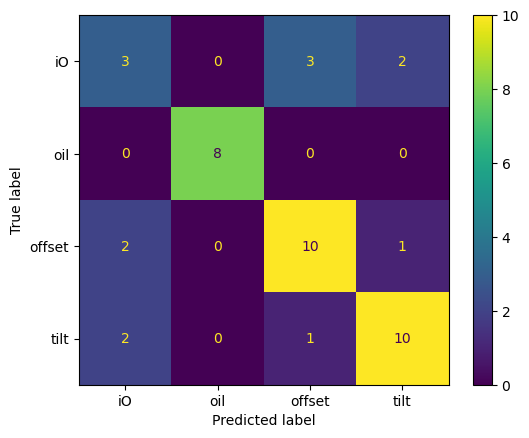

In [ ]:
#Train and evaluate the model


history = model.fit(
    train_input, y_train,
    validation_data=(val_input, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

y_pred = model.predict(val_input).argmax(axis=1)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=["iO", "oil", "offset", "tilt"]))

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["iO", "oil", "offset", "tilt"]).plot()
plt.show()
